### Notebook for Figure 7, SCeptre analysis of the integrated dataset.

In [1]:
%matplotlib inline
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanorama
import scanpy as sc
import sceptre as spt

## Preparation
Create meta data table and load files into python as "dataset". Alternatively, a meta data table could be created manually and be provided to the function: sceptre.load_dataset()
Mapping is performed with the "File ID" and "Channel" columns.

In [2]:
# create result folder
res_dir = '../results/integrated/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [3]:
spt.create_meta_data("../data/integrated/", res_dir)

In [4]:
dataset = spt.load_dataset(proteins = "../data/integrated/integrated_Proteins.txt",
                           psms = "../data/integrated/integrated_PSMs.txt",
                           msms = "../data/integrated/integrated_MSMSSpectrumInfo.txt",
                           files = "../data/integrated/integrated_InputFiles.txt",
                           meta = res_dir + "meta.txt")

In [5]:
# mark and remove potential contaminants
contaminants = pd.read_table('../data/contaminants.txt')['Accession']
dataset['proteins']['contaminant'] = dataset['proteins']['Accession'].isin(contaminants)
dataset['proteins'] = dataset['proteins'][dataset['proteins']['contaminant']==False]

In [6]:
figwd = 7.2 # standard figwidth

## LC-MS QC
Plot various visualizations that inform about the quality of each LC-MS run

In [7]:
s_c_channels = ['128N', '128C', '129N', '129C', '130N', '130C', '131N',
                '131C', '132N', '132C', '133N', '133C', '134N']
spt.print_ms_stats(dataset, s_c_channels=s_c_channels)

Protein IDs: 3012
Peptide IDs: 18576
PSMs: 1005707
PSM rate: 0.286
Median of median S/N in single-cell channels: 6.1
Median of mean S/N in single-cell channels: 9.638
Median S/N of booster channel: 766.4
Mean protein IDs per file: 1215.492


## Load data into Scanpy

In [8]:
adata = spt.dataset_to_scanpy(dataset)
adata

AnnData object with n_obs × n_vars = 3840 × 2976
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'APC-Cy7-A', 'PE-A', 'Time', 'Gated Population'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways'

In [9]:
# transform meta columns to categories
adata.obs["Column"] = adata.obs["Column"].astype(pd.Int64Dtype()).astype("category")
adata.obs["Plate"] = adata.obs["Plate"].astype(str).astype("category")
# object columns to category
adata.obs.loc[:, adata.obs.dtypes == "object"] = adata.obs.select_dtypes(["object"]
                                                                          ).apply(lambda x: x.astype("category"))
# order some columns
adata.obs["File ID"] = adata.obs["File ID"].cat.reorder_categories(adata.obs["File ID"].unique(), ordered=True)
adata.obs["Channel"] = adata.obs["Channel"].cat.reorder_categories(adata.obs["Channel"].unique(), ordered=True)

# normalize facs parameter between 0 and 1
fasc_params = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'APC-Cy7-A', 'PE-A']
adata.obs[fasc_params] = adata.obs[fasc_params].apply(lambda x: (x-x.min())/(x-x.min()).max())
# rename the facs parameter
adata.obs = adata.obs.rename(columns={'APC-Cy7-A': 'CD34 APC-Cy7-A', 'PE-A': 'CD38 PE-A'})

# set colors for gated and sorted populations
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
adata.uns['Sorted Population_colors'] = [cols[0], cols[1], cols[2]]
adata.uns['Gated Population_colors'] = [cols[3], cols[0], cols[1], cols[2]]

In [10]:
adata

AnnData object with n_obs × n_vars = 3840 × 2976
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A', 'Time', 'Gated Population'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways'
    uns: 'Sorted Population_colors', 'Gated Population_colors'

## Filter samples, channels and groups of cells

In [11]:
# remove failed ms runs
adata = adata[~adata.obs['File ID'].isin(['F18', 'F24', 'F29', 'F68', 'F82', 'F141', 'F212'])].copy()
# failed rows on the 500ms plate
adata = adata[~((adata.obs['Plate']=='500ms') & (adata.obs['Row'].isin(['I', 'J'])))].copy()
# remove non-single-cell cannel
adata = adata[~adata.obs['Channel'].isin(['126', '127C'])].copy()
adata = adata[~((~adata.obs['Plate'].isin(['500ms'])) & (adata.obs['Channel'].isin(['127N'])))].copy()
adata = adata[~adata.obs['Sorted Population'].isin(['empty'])].copy()

/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Normalization

First, normalize the bulk and enriched separately using the sceptre function. After imputation, both datasets are integrated using scanorama.

In [12]:
adata.obs['Plate'].cat.categories

Index(['500ms', 'bulk_b_1', 'bulk_b_2', 'bulk_b_3', 'bulk_b_e_1', 'bulk_b_e_2',
       'bulk_c_1', 'bulk_c_2', 'bulk_c_3', 'enriched'],
      dtype='object')

In [13]:
# protein valid value filter
missing_thresh = 0.4

## enriched

performed 43 iterations
567 values below 1.1 were set to 0
filtered out 603 genes that are detected in less than 1 cells
65 of 576 cells do not pass filter
removed 65 cells
filtered out 78 genes that are detected in less than 3 cells
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['VIM', 'S100A8']
    finished (0:00:00)


AnnData object with n_obs × n_vars = 511 × 991
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A', 'Time', 'Gated Population', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways', 'n_cells'
    uns: 'Gated Population_colors', 'Channel_colors', 'Sorted Population_colors', 'log1p'

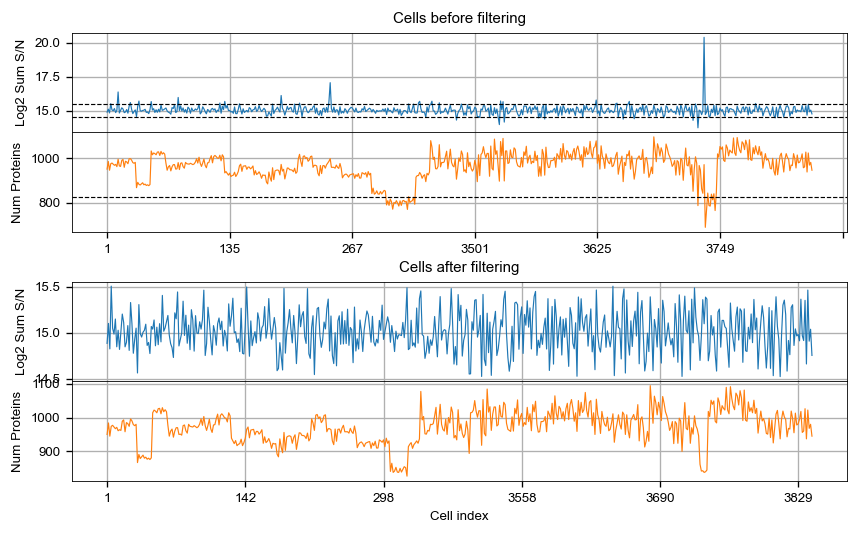

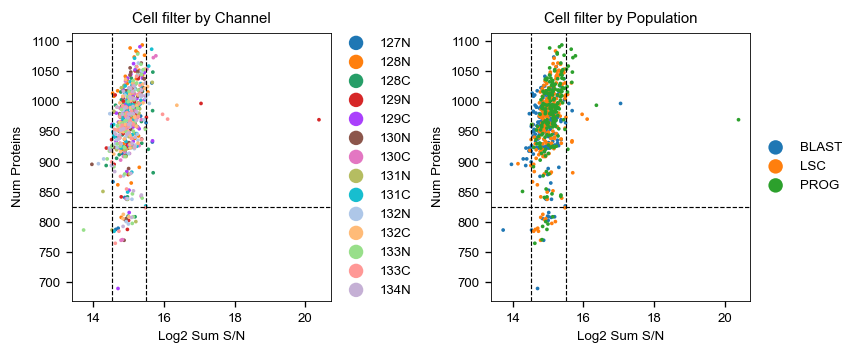

In [14]:
en_ad = adata[adata.obs['Plate'].isin(['enriched', '500ms'])].copy()
spt.normalize(en_ad)
figs = spt.calculate_cell_filter(en_ad, thresh_sum=2, min_proteins=825)
spt.apply_cell_filter(en_ad)

# median shift of total intensity across cells
sc.pp.normalize_total(en_ad, exclude_highly_expressed=True) 
# log2(x+1) transformation
sc.pp.log1p(en_ad, base=2)

# apply the "fraction of valid values" filter on the proteins
en_ad = en_ad[:, (en_ad.X != 0).sum(axis=0) >= en_ad.obs.shape[0]*missing_thresh].copy()
# impute for the embedding
spt.impute(en_ad)
en_ad

### bulk

performed 17 iterations
5321 values below 1.1 were set to 0
filtered out 183 genes that are detected in less than 1 cells
381 of 2384 cells do not pass filter
removed 381 cells
filtered out 59 genes that are detected in less than 3 cells
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['S100A8', 'NME1-NME2; NME1; NME2', 'CTSG', 'S100A9', 'LYZ']
    finished (0:00:00)


AnnData object with n_obs × n_vars = 2003 × 1007
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A', 'Time', 'Gated Population', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways', 'n_cells'
    uns: 'Gated Population_colors', 'Channel_colors', 'Sorted Population_colors', 'log1p'

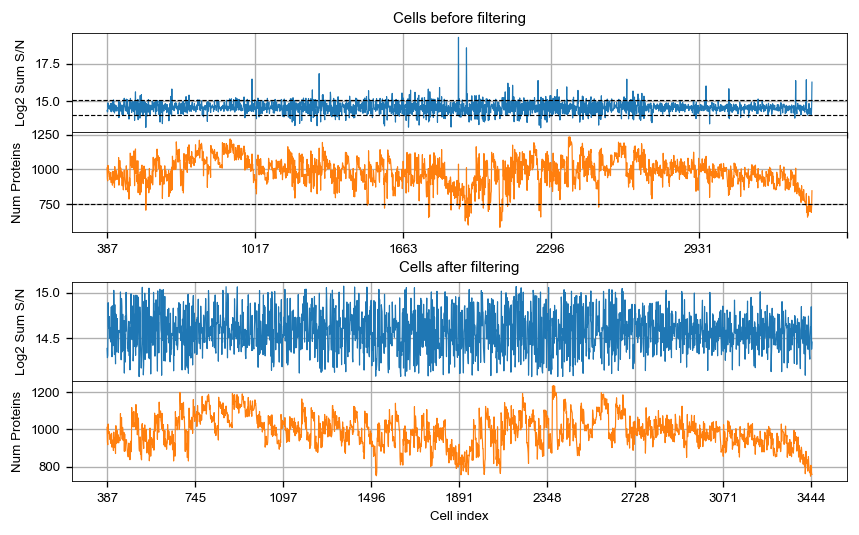

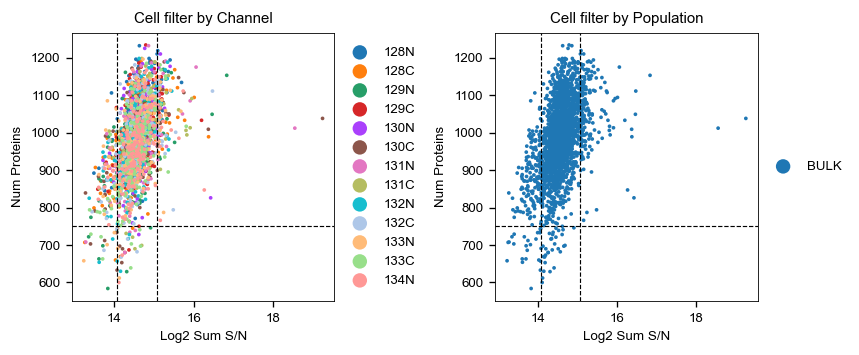

In [15]:
bulk_ad = adata[~adata.obs['Plate'].isin(['500ms', 'enriched'])].copy()
spt.normalize(bulk_ad)
figs = spt.calculate_cell_filter(bulk_ad, thresh_sum=1.8, min_proteins=750)
spt.apply_cell_filter(bulk_ad)

# median shift of total intensity across cells
sc.pp.normalize_total(bulk_ad, exclude_highly_expressed=True) 
# log2(x+1) transformation
sc.pp.log1p(bulk_ad, base=2)

# apply the "fraction of valid values" filter on the proteins
bulk_ad = bulk_ad[:, (bulk_ad.X != 0).sum(axis=0) >= bulk_ad.obs.shape[0]*missing_thresh].copy()
# impute for the embedding
spt.impute(bulk_ad)
bulk_ad

In [16]:
adatas = [bulk_ad, en_ad]

In [17]:
var_anno = adata.var.copy()

In [18]:
adata = sc.AnnData.concatenate(*adatas, join='inner')
adata.var = pd.DataFrame(index=adata.var.index)

In [19]:
# scanorama
dats = [adata[adata.obs['batch']==b].copy() for b in adata.obs['batch'].unique()]
corr_dats = scanorama.correct_scanpy(dats, return_dense=True)
adata_corr = corr_dats[0].concatenate(corr_dats[1:])
# reorder genes
adata_corr = adata_corr[:, dats[0].var.index]
adata = adata_corr.copy()
adata.var = adata.var.merge(var_anno, how='left', left_index=True, right_index=True)

Found 917 genes among all datasets
[[0.         0.53816047]
 [0.         0.        ]]
Processing datasets (0, 1)


... storing 'File ID' as categorical
... storing 'Channel' as categorical
... storing 'File Name' as categorical
... storing 'Plate' as categorical
... storing 'Well' as categorical
... storing 'Sorted Population' as categorical


BLAST CD38-    1586
BLAST CD38+     488
LSC             259
PROG            181
Name: Gated Population, dtype: int64


/mnt/c/Users/qlj874/OneDrive - Københavns Universitet/Documents/SCeptre/sceptre/sceptre.py:1056: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


AnnData object with n_obs × n_vars = 2514 × 917
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A', 'Time', 'Gated Population', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter', 'batch'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways'
    uns: 'Sorted Population_colors', 'Gated Population_colors'

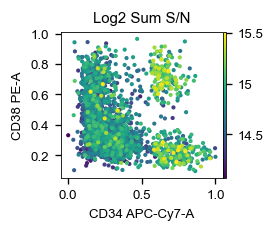

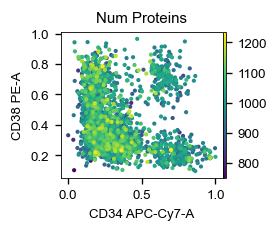

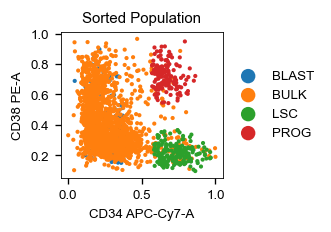

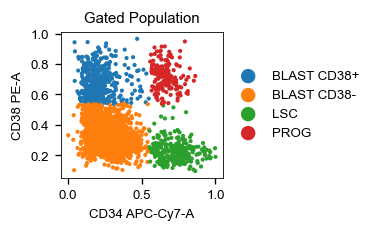

In [20]:
print(adata.obs['Gated Population'].value_counts())
figs = spt.plot_facs_qc(adata, 'CD34 APC-Cy7-A', 'CD38 PE-A')
for i, f in enumerate(figs):
    f.savefig(res_dir + "facs_qc_{}.pdf".format(i), bbox_inches='tight', transparent=True)
adata

In [21]:
plot_parameters = ['batch', 'Plate', 'Sorted Population', 'Gated Population', 'Channel', 'Log2 Sum S/N',
                   'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A']
plot_cmaps = {'Num Proteins': 'copper', 'Log2 Sum S/N': 'copper', 'Time': 'copper',
             'FSC-A': 'cividis', 'FSC-H': 'cividis', 'FSC-W': 'cividis', 'SSC-A': 'cividis',
             'SSC-H': 'cividis', 'SSC-W': 'cividis', 'CD34 APC-Cy7-A': 'cividis',
             'CD38 PE-A': 'cividis', 'dpt_pseudotime': 'copper'}

# set colors for gated and sorted populations
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
adata.uns['Sorted Population_colors'] = [cols[0], cols[1], cols[2]]
adata.uns['Gated Population_colors'] = [cols[3], cols[0], cols[1], cols[2]]

cellsize= 10 # size to plot cells

computing PCA
    with n_comps=50
    finished (0:00:11)


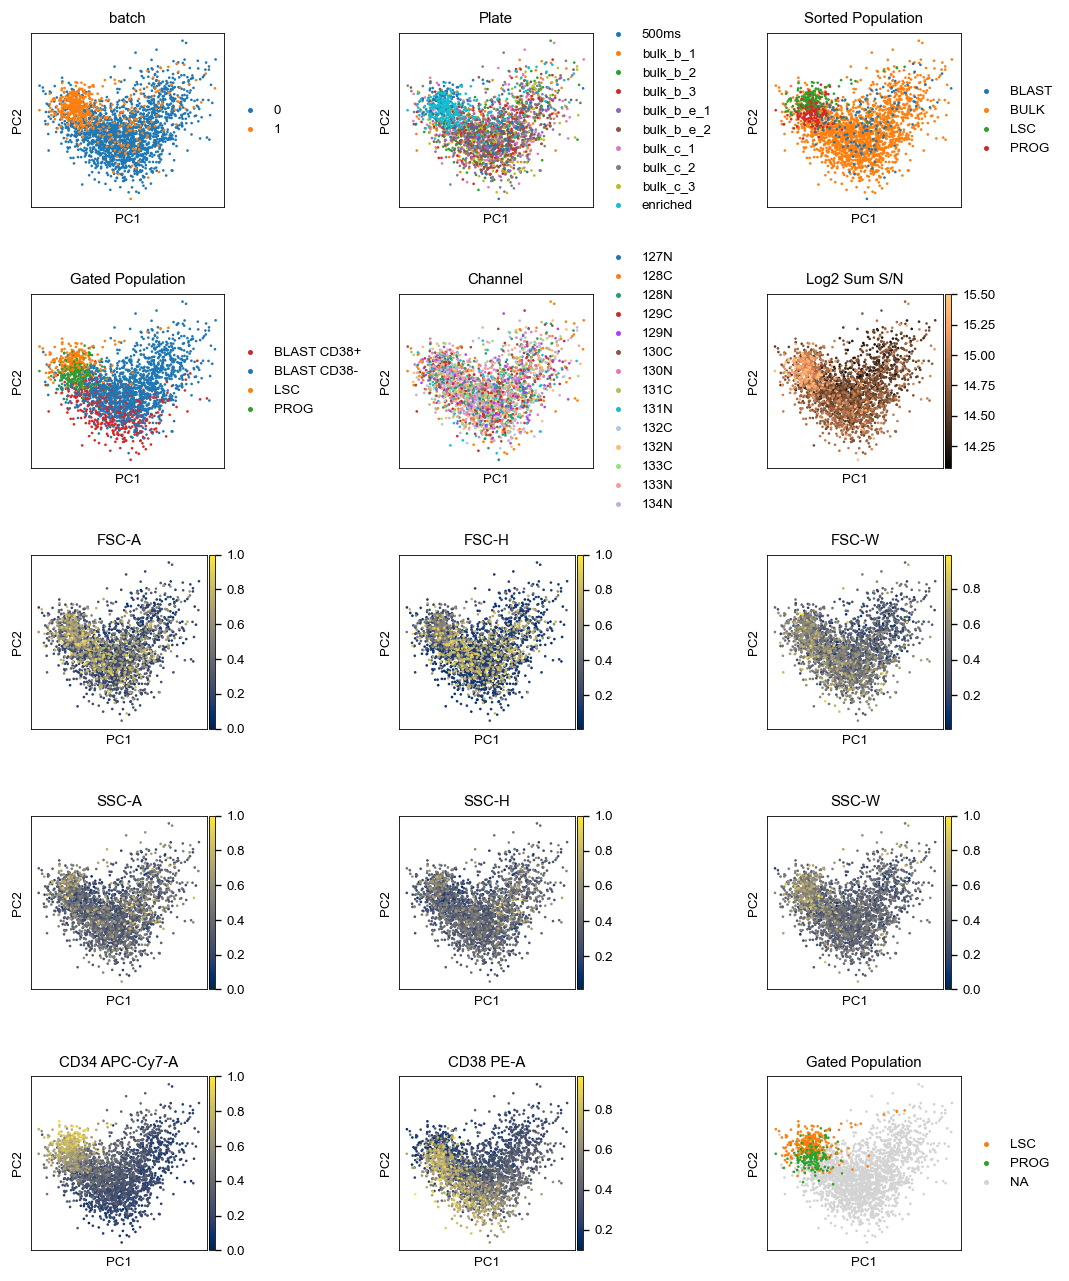

In [22]:
sc.pp.pca(adata)
fig = plt.figure(figsize=(10, 16))
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(6, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.pca(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax)
plt.subplots_adjust(wspace=0.9, hspace=0.5)
ax = fig.add_subplot(6, 3, i+2)
sc.pl.pca(adata, color=['Gated Population'], groups=['LSC', 'PROG'], size=cellsize, show=False, ax=ax)
fig.savefig(res_dir + "pca.pdf", bbox_inches='tight', transparent=True)

In [23]:
sc.pp.neighbors(adata, n_neighbors=30, random_state=1)
sc.tl.umap(adata)
sc.tl.draw_graph(adata)
sc.tl.diffmap(adata)
sc.tl.leiden(adata, resolution=0.5)

# define root cell from diffmap
root = adata.obs.index[pd.DataFrame(adata.obsm['X_diffmap']).sort_values(by=[1, 2], ascending=True).index[0]]
adata.obs.loc[:, 'Root Cell'] = 0
adata.obs.loc[root, 'Root Cell'] = 1
adata.uns['iroot'] = np.flatnonzero(adata.obs['Root Cell'] == 1)[0]

sc.tl.dpt(adata)

if 'leiden' not in plot_parameters:
    plot_parameters.append('leiden')
if 'dpt_pseudotime' not in plot_parameters:
    plot_parameters.append('dpt_pseudotime')

figsize = (8, 16)
wspace = 0.9
hspace = 0.5

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:15)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9809414  0.9548251  0.9079401  0.89644736 0.8781034
     0.8601653  0.8363095  0.82630605 0.80263525 0.7981042  0.7806303
     0.7756318  0.7725958  0.7562049 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:03)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluste

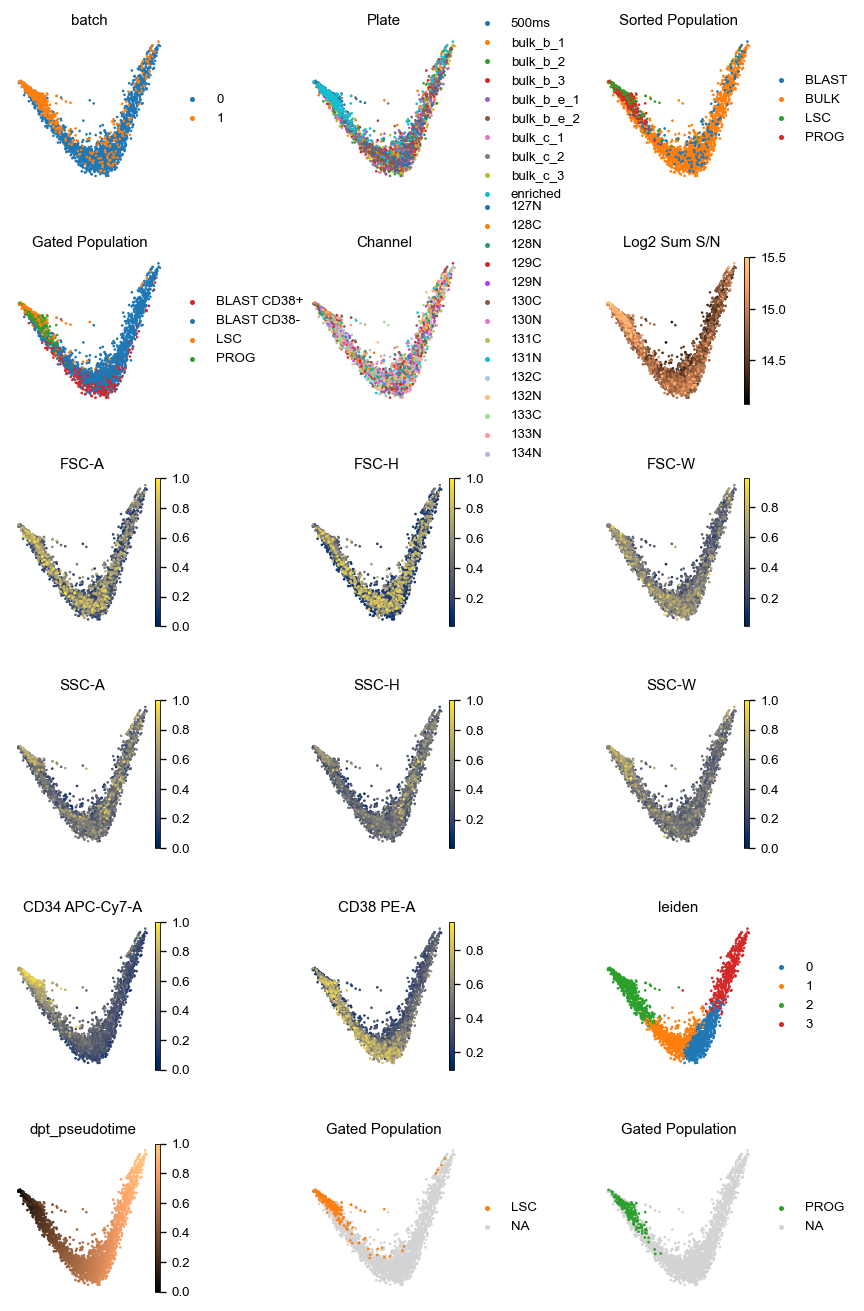

In [24]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(7, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.diffmap(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax, frameon=False)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
ax = fig.add_subplot(7, 3, i+2)
sc.pl.diffmap(adata, color=['Gated Population'], groups=['LSC'], size=cellsize, show=False, ax=ax, frameon=False)
ax = fig.add_subplot(7, 3, i+3)
sc.pl.diffmap(adata, color=['Gated Population'], groups=['PROG'], size=cellsize, show=False, ax=ax, frameon=False)
fig.savefig(res_dir + "diffmap.pdf", bbox_inches='tight', transparent=True)

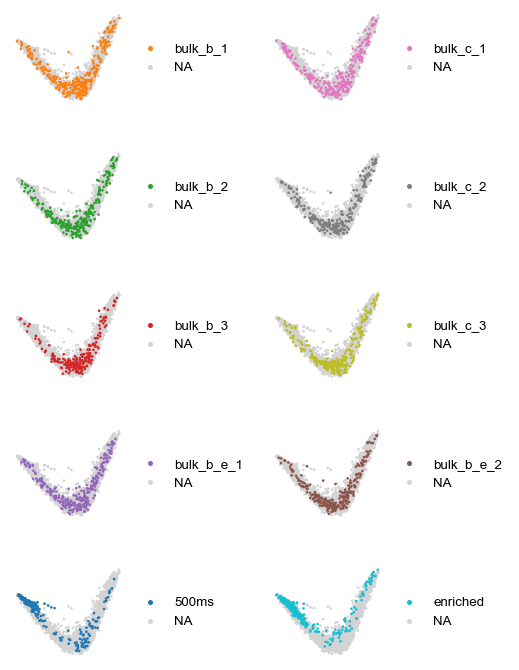

In [25]:
fig, axs = plt.subplots(5, 2, figsize=(4, 7), gridspec_kw={'wspace': 1.3, 'hspace' :0.5})
axs = axs.flatten()
for i, p in enumerate(adata.obs['Plate'].unique()):
    sc.pl.diffmap(adata, color='Plate', size=cellsize, groups=p, show=False, ax=axs[i],
                  frameon=False, title="")
fig.savefig(res_dir + "plate_integration_diffmap.pdf", bbox_inches='tight', transparent=True)

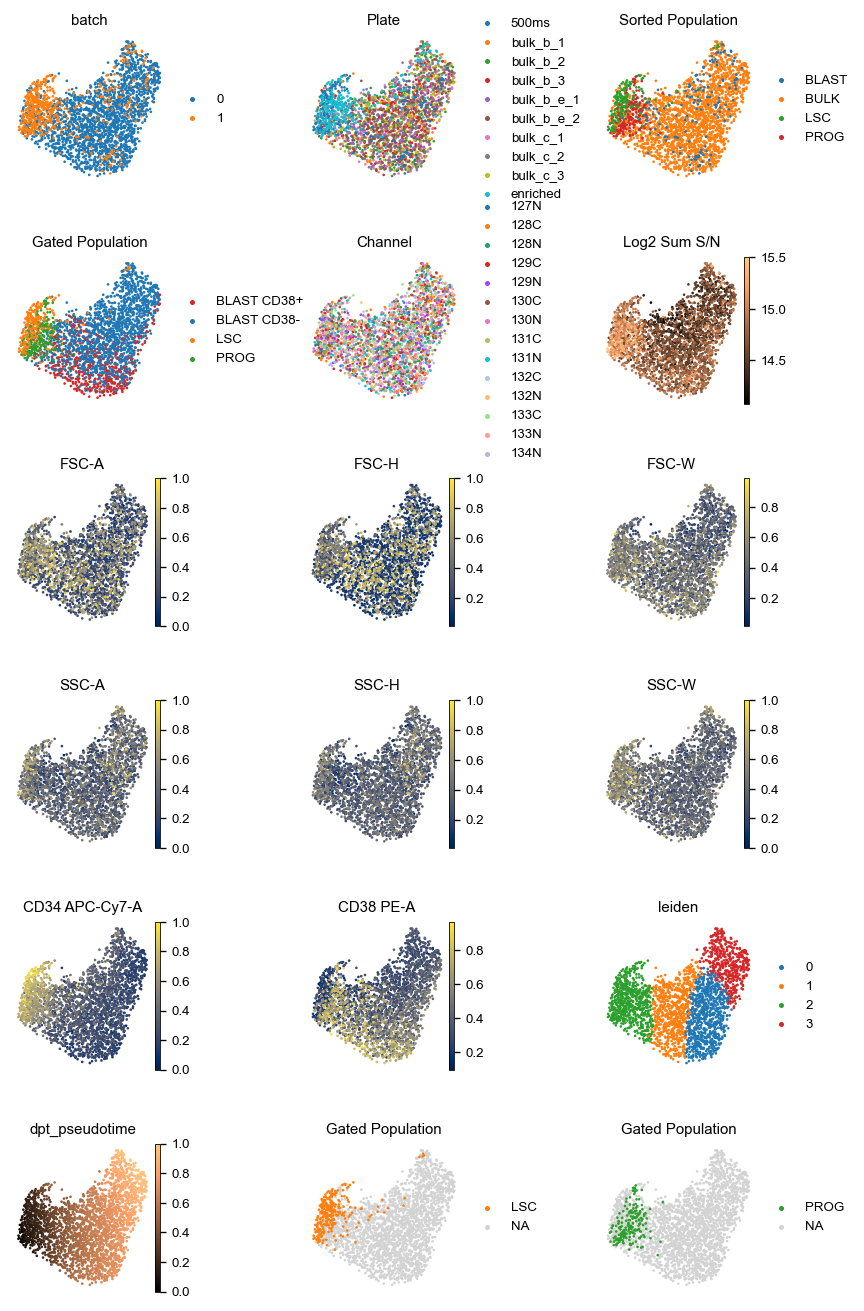

In [26]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(7, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.umap(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax, frameon=False)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
ax = fig.add_subplot(7, 3, i+2)
sc.pl.umap(adata, color=['Gated Population'], groups=['LSC'], size=cellsize, show=False, ax=ax, frameon=False)
ax = fig.add_subplot(7, 3, i+3)
sc.pl.umap(adata, color=['Gated Population'], groups=['PROG'], size=cellsize, show=False, ax=ax, frameon=False)
fig.savefig(res_dir + "umap.pdf", bbox_inches='tight', transparent=True)

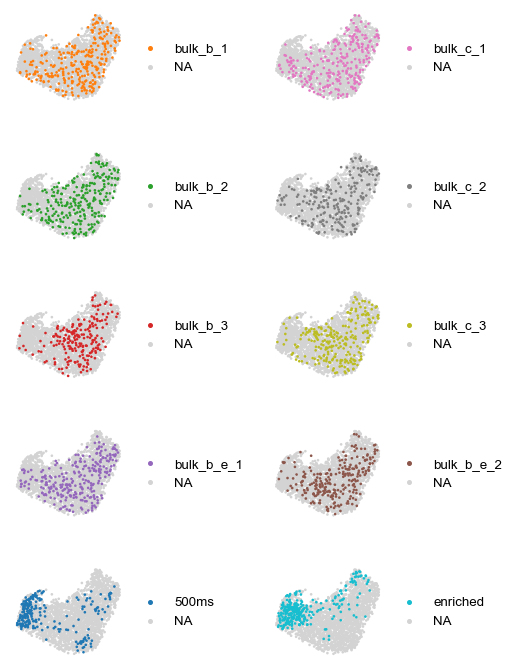

In [27]:
fig, axs = plt.subplots(5, 2, figsize=(4, 7), gridspec_kw={'wspace': 1.3, 'hspace' :0.5})
axs = axs.flatten()
for i, p in enumerate(adata.obs['Plate'].unique()):
    sc.pl.umap(adata, color='Plate', size=cellsize, groups=p, show=False, ax=axs[i],
                  frameon=False, title="")
fig.savefig(res_dir + "plate_integration_umap.pdf", bbox_inches='tight', transparent=True)

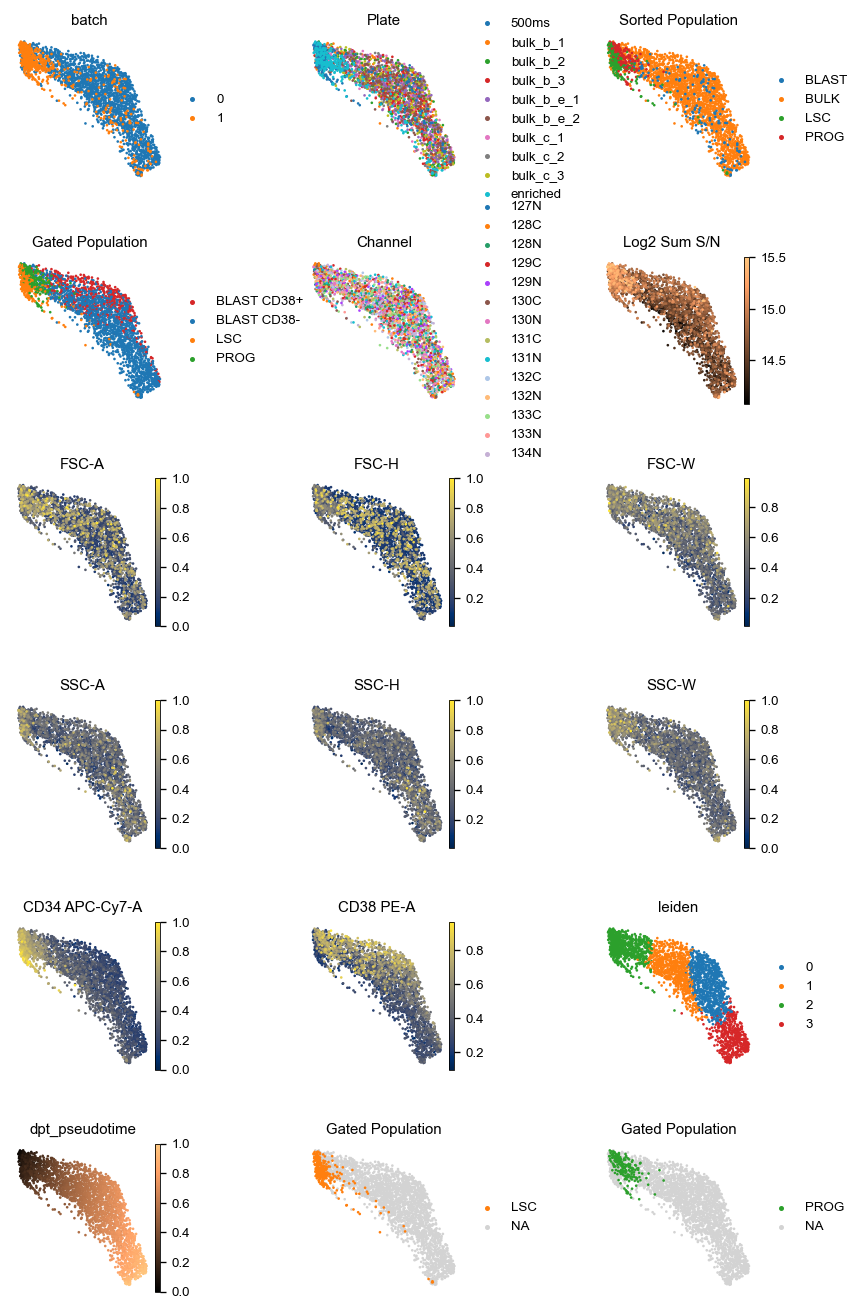

In [28]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(7, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.draw_graph(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax, frameon=False)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
ax = fig.add_subplot(7, 3, i+2)
sc.pl.draw_graph(adata, color=['Gated Population'], groups=['LSC'], size=cellsize, show=False, ax=ax, frameon=False)
ax = fig.add_subplot(7, 3, i+3)
sc.pl.draw_graph(adata, color=['Gated Population'], groups=['PROG'], size=cellsize, show=False, ax=ax, frameon=False)
fig.savefig(res_dir + "fa.pdf", bbox_inches='tight', transparent=True)

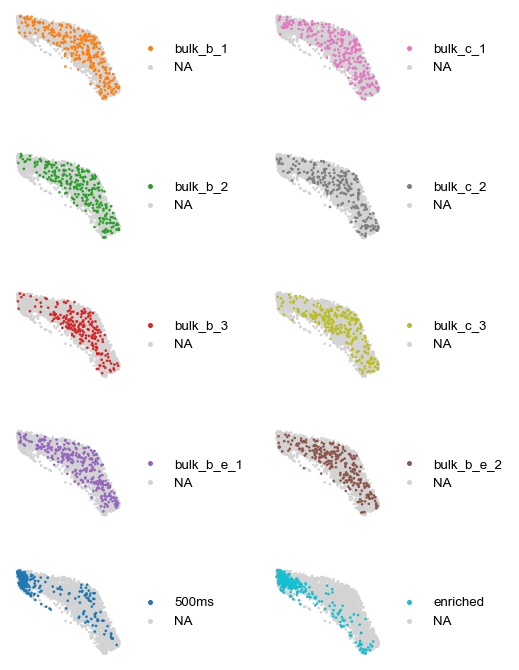

In [29]:
fig, axs = plt.subplots(5, 2, figsize=(4, 7), gridspec_kw={'wspace': 1.3, 'hspace' :0.5})
axs = axs.flatten()
for i, p in enumerate(adata.obs['Plate'].unique()):
    sc.pl.draw_graph(adata, color='Plate', size=cellsize, groups=p, show=False, ax=axs[i],
                  frameon=False, title="")
fig.savefig(res_dir + "plate_integration_fa.pdf", bbox_inches='tight', transparent=True)

In [37]:
# find changing genes
cell_cl = adata.obs['leiden'].unique()
log2fc = 1.03
markers = {k:[] for k in cell_cl}
for i in cell_cl:
    spt.de_test(adata, by='leiden', group1=i, key='de_test_{}'.format(i), use_raw=False, is_log=False)
    df = adata.uns['de_test_{}'.format(i)]['results']
    df['group'] = i
    df['log2foldchange'] = df['log2foldchange'].astype(float)
    markers[i] = df[(df['pval_adj'] <= 0.05) & (df['log2foldchange'] >= log2fc)]
markers = pd.concat(markers.values())
# remove duplicate genes by keeping it in the group with the highest foldchange
markers = markers.sort_values('log2foldchange', ascending=False).drop_duplicates('gene')

In [38]:
markers

gene           pval  log2foldchange  size1  size2       pval_adj  \
250    S100A9  1.648570e-179        1.593857    444   2070  7.558693e-177   
884  HLA-DRB1  4.292261e-181        1.537105    628   1886  1.405715e-179   
145    S100A8  1.147905e-200        1.507233    444   2070  1.052629e-197   
887   S100A12   1.027938e-75        1.374254    444   2070   1.520354e-74   
880    S100A6   9.481389e-94        1.368247    444   2070   2.021961e-92   
..        ...            ...             ...    ...    ...            ...   
282     RPS19   1.868687e-44        1.030326    628   1886   6.346614e-44   
158     CAPZB   3.546796e-46        1.030250    444   2070   2.339865e-45   
882      UFM1   5.754386e-08        1.030154    689   1825   2.964479e-07   
207     ARPC2   5.574287e-26        1.030077    444   2070   1.799867e-25   
598     DECR1   5.903609e-08        1.030075    444   2070   1.047120e-07   

    group  
250     3  
884     2  
145     3  
887     3  
880     3  
..    ...  
282     2  
158     3  
882     1  
207     3  
598     3  

[481 rows x 7 columns]

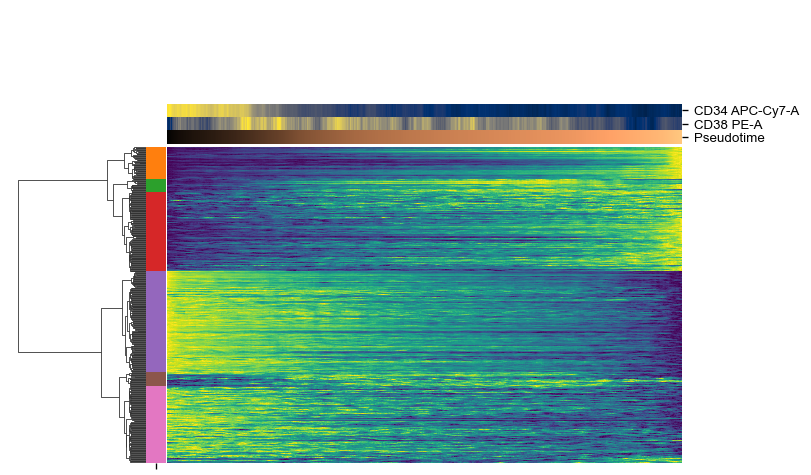

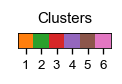

In [32]:
clusters, cl_map, cl_legend = spt.ordered_clustermap(adata, markers['gene'],
                                                     use_raw=False, n_cluster=6, plot_imputed=False,
                                                     moving_avg=50, figsize=(6.8, 4), show_gene_names=False)
cl_map.savefig(res_dir + 'ordered_clustermap_smooth.pdf', bbox_inches='tight', transparent=True)
cl_legend.savefig(res_dir + 'ordered_clustermap_smooth_legend.pdf', bbox_inches='tight', transparent=True)

In [40]:
markers = markers.merge(clusters)
markers = markers.merge(adata.var[['Accession', 'Description', 'Biological Process', 'Cellular Component',
           'Molecular Function','KEGG Pathways', 'Reactome Pathways', 'WikiPathways']],
              how='left', left_on='gene', right_index=True)
markers = markers.drop(['pval', 'size1', 'size2', 'pval_adj', 'group'], axis=1)
markers.to_excel(res_dir + 'markers.xls')

In [33]:
# aggregate each cluster into a signature
clus = clusters['cluster'].unique()
from scipy.stats import mstats
for c in clus:
    adata.obs[f'Cluster {c}'] = adata[:, clusters[clusters['cluster']==c]['gene']].X.mean(axis=1)
# normalize
adata.obs[[f'Cluster {c}' for c in clus]] = adata.obs[[f'Cluster {c}' for c in clus]
                                                     ].apply(lambda x: (x-x.min())/(x-x.min()).max())

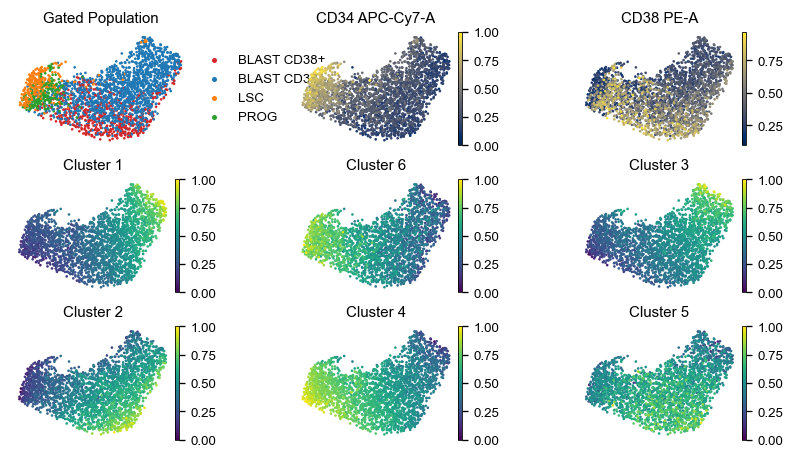

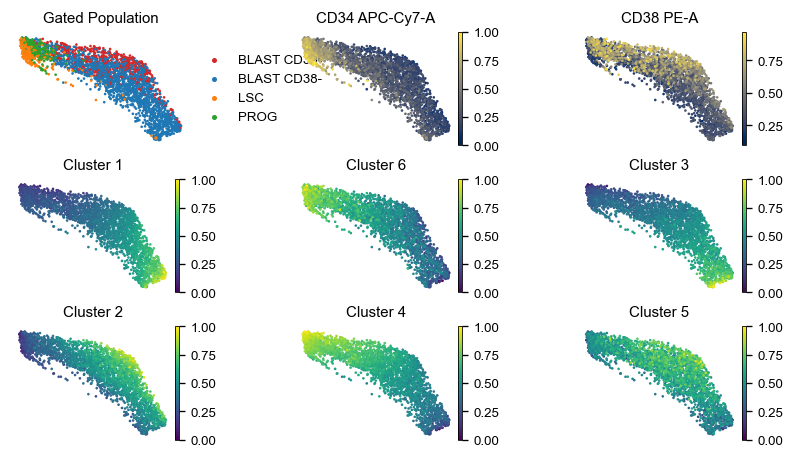

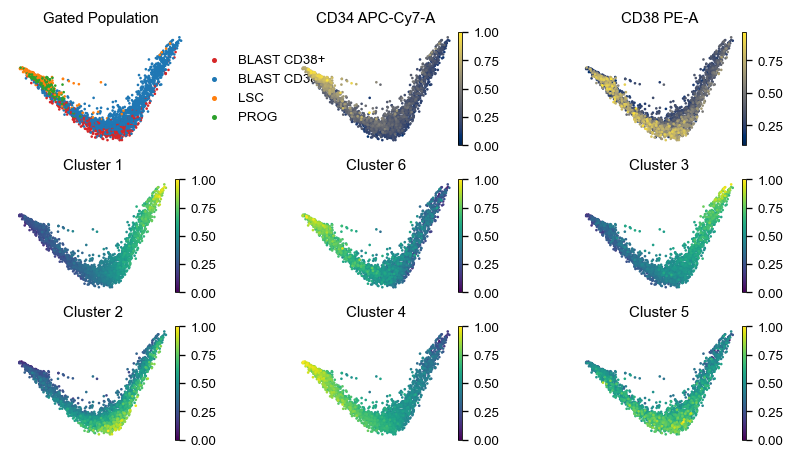

In [34]:
# plot the cluster signature
genes = ['Gated Population', 'CD34 APC-Cy7-A', 'CD38 PE-A'] + [f'Cluster {c}' for c in clusters['cluster'].unique()]
n_row = int((len(genes)/3)+1)

fig = plt.figure(figsize=(8, 6))
for i, p in enumerate(genes):
    ax = fig.add_subplot(n_row, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.umap(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax, frameon=False)
plt.subplots_adjust(wspace=0.6, hspace=0.3)
fig.savefig(res_dir + "umap_clusters.pdf", bbox_inches='tight', transparent=True)

fig = plt.figure(figsize=(8, 6))
for i, p in enumerate(genes):
    ax = fig.add_subplot(n_row, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.draw_graph(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax, frameon=False)
plt.subplots_adjust(wspace=0.6, hspace=0.3)
fig.savefig(res_dir + "fa_clusters.pdf", bbox_inches='tight', transparent=True)

fig = plt.figure(figsize=(8, 6))
for i, p in enumerate(genes):
    ax = fig.add_subplot(n_row, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.diffmap(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax, frameon=False)
plt.subplots_adjust(wspace=0.6, hspace=0.3)
fig.savefig(res_dir + "diffmap_clusters.pdf", bbox_inches='tight', transparent=True)

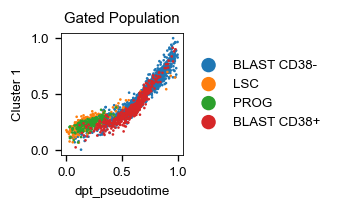

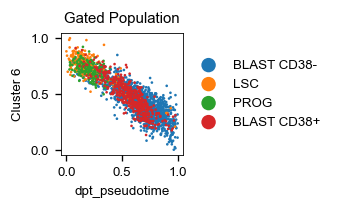

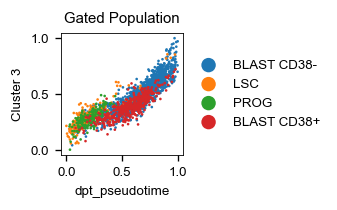

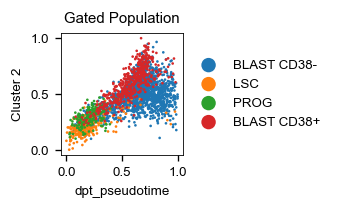

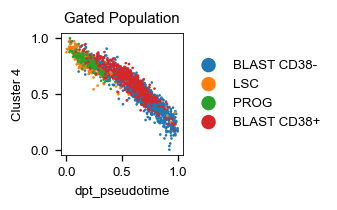

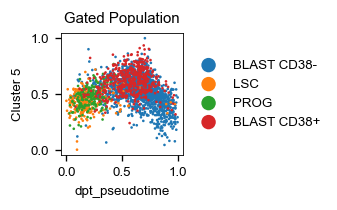

In [35]:
curr = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (2.4, 1.4)
for c in clusters['cluster'].unique():
    sc.pl.scatter(adata, x='dpt_pseudotime', y=f'Cluster {c}', color='Gated Population',
                  groups=['BLAST CD38-', 'LSC', 'PROG', 'BLAST CD38+'], size=10, alpha=1, show=False)
    plt.savefig(res_dir + f"cluster{c}_pseudotime.pdf", bbox_inches='tight', transparent=True)
plt.rcParams["figure.figsize"] = curr

In [36]:
# term enrichment test
for c in clusters['cluster'].unique():
    spt.enrichment_test(adata, gene_set=clusters[clusters['cluster']==c]['gene'].values,
                        categories=['Biological Process', 'Cellular Component', 'Molecular Function',
                                    'KEGG Pathways', 'Reactome Pathways', 'WikiPathways'],
                        key=f'Cluster {c}', use_raw=False)
    adata.uns[f'Cluster {c}'].to_excel(res_dir + "terms_cluster_{}.xls".format(c))

In [37]:
clusters[clusters['cluster']==5]

gene  cluster
157  P04439-2        5
208       B2M        5
266       ADA        5
301     EWSR1        5
309    O75477        5
311     STT3A        5
344      CALR        5
349    DAZAP1        5
355    Q9P2E9        5
360   ABHD14B        5
364    PYCARD        5
367     PDIA6        5
376     HLA-B        5
414   TMEM173        5
425      PLEK        5
435    MAPK14        5
453    RSL1D1        5
454     SAR1A        5
459   TXNDC12        5
461     PDCD4        5
472     SLIRP        5
478      UFM1        5

In [38]:
adata.uns[f'Cluster {5}'].head(40)

size background  \
endoplasmic reticulum                                         917.0   
 Antigen Presentation: Folding, assembly and pe...            917.0   
nan                                                           917.0   
 Immunoregulatory interactions between a Lympho...            917.0   
 Endosomal/Vacuolar pathway                                   917.0   
nan                                                           917.0   
 RIG-I-like receptor signaling pathway                        917.0   
Golgi                                                         917.0   
Cytosolic DNA-sensing pathway                                 917.0   
 NOD-like receptor signaling pathway                          917.0   
cell surface                                                  917.0   
cell differentiation                                          917.0   
 Interferon gamma signaling                                   917.0   

                                                    # in background  \
endoplasmic reticulum                                         105.0   
 Antigen Presentation: Folding, assembly and pe...              7.0   
nan                                                           153.0   
 Immunoregulatory interactions between a Lympho...              3.0   
 Endosomal/Vacuolar pathway                                     3.0   
nan                                                            15.0   
 RIG-I-like receptor signaling pathway                          2.0   
Golgi                                                          58.0   
Cytosolic DNA-sensing pathway                                   3.0   
 NOD-like receptor signaling pathway                           11.0   
cell surface                                                   41.0   
cell differentiation                                          115.0   
 Interferon gamma signaling                                     5.0   

                                                    size subset  # in subset  \
endoplasmic reticulum                                      22.0          9.0   
 Antigen Presentation: Folding, assembly and pe...         22.0          3.0   
nan                                                        22.0         10.0   
 Immunoregulatory interactions between a Lympho...         22.0          2.0   
 Endosomal/Vacuolar pathway                                22.0          2.0   
nan                                                        22.0          3.0   
 RIG-I-like receptor signaling pathway                     22.0          2.0   
Golgi                                                      22.0          5.0   
Cytosolic DNA-sensing pathway                              22.0          2.0   
 NOD-like receptor signaling pathway                       22.0          3.0   
cell surface                                               22.0          4.0   
cell differentiation                                       22.0          8.0   
 Interferon gamma signaling                                22.0          2.0   

                                                    expected  enrichment  \
endoplasmic reticulum                               2.519084    3.572727   
 Antigen Presentation: Folding, assembly and pe...  0.167939   17.863636   
nan                                                 3.670665    2.724302   
 Immunoregulatory interactions between a Lympho...  0.071974   27.787879   
 Endosomal/Vacuolar pathway                         0.071974   27.787879   
nan                                                 0.359869    8.336364   
 RIG-I-like receptor signaling pathway              0.047983   41.681818   
Golgi                                               1.391494    3.593260   
Cytosolic DNA-sensing pathway                       0.071974   27.787879   
 NOD-like receptor signaling pathway                0.263904   11.367769   
cell surface                                        0.983642    4.066519   
cell differentiation         

In [39]:
# save adata
adata.write(res_dir + "integrated.h5ad")

In [40]:
os.system('jupyter nbconvert --to html integrated.ipynb --output-dir={}'.format(res_dir))

0